## Ground State Calculation 
## Bandstructure with high-symmetry path along with elecronic band gap


In [3]:
import matplotlib.pyplot as plt
# change defaults to make plots bigger
plt.rcParams['figure.figsize'] = [8, 6]
plt.rcParams['figure.dpi'] = 100 # 200 dpi is really fine, but slower (i.e. for publication)

In [4]:
from ase.spacegroup import crystal
from ase.visualize import view
from ase.io import read
from ase.build import bulk
from ase.optimize import BFGS
from ase.optimize import BFGSLineSearch
from gpaw import GPAW, PW, FermiDirac
import matplotlib.pyplot as plt
from ase.dft.dos import DOS
from ase.constraints import UnitCellFilter
from ase.build import mx2
from gpaw import *
from ase.constraints import StrainFilter
from gpaw import GPAW, PW, Davidson
from gpaw.hybrids import HybridXC
from gpaw.xc.vdw import VDWFunctional
from gpaw.hybrids.eigenvalues import non_self_consistent_eigenvalues
vdw = VDWFunctional('vdW-DF2', Nalpha=24)
from gpaw import GPAW, setup_paths
from gpaw.poisson import PoissonSolver
from gpaw.occupations import FermiDirac
from gpaw.test import equal, gen
'''
atoms=read('MoSMoS.traj')
calc = GPAW(mode=PW(600),
            xc='vdW-DF2',
            nbands=70,
            convergence={'bands': -20},
            setups={'Mo': '6'},
            occupations=FermiDirac(width=0.01),
            kpts={'size': (42, 42, 1), 'gamma': True})  
atoms.calc = calc
atoms.get_potential_energy()
calc.write('PBE.gpw', mode='all')
'''
atoms, calc=restart('../thermoelectric/gs_new.gpw')

In [5]:
# OK, sanity checks on that calculation!
# What is the band-gap, and does it look sensible?
from ase.dft.bandgap import bandgap
gap, p1, p2 = bandgap(atoms.calc)
# Output is the gap in eV
# and from where the VBM in k-space is, and where the CBM is.
# From here you can appreciate whether the material is direct or not.

Gap: 1.463 eV
Transition (v -> c):
  (s=0, k=0, n=17, [-0.00, -0.00, 0.00]) -> (s=0, k=64, n=18, [0.33, 0.33, 0.00])


HEX(a=3.18407, c=15.4252)
  Variant name: HEX
  Special point names: GMKALH
  Default path: GMKGALHA,LM,KH

  Special point coordinates:
    G   0.0000  0.0000  0.0000
    M   0.5000  0.0000  0.0000
    K   0.3333  0.3333  0.0000
    A   0.0000  0.0000  0.5000
    L   0.5000  0.0000  0.5000
    H   0.3333  0.3333  0.5000



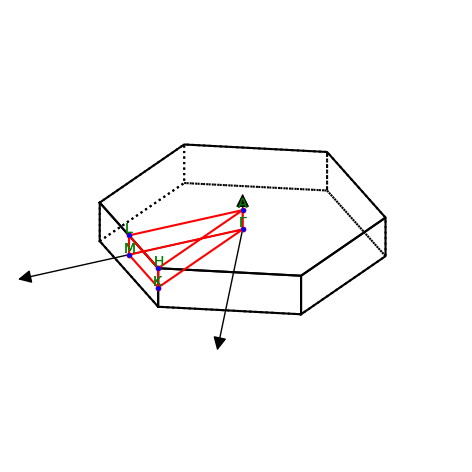

<Axes3DSubplot:>

In [6]:
# OK! Luckily ASE knows all about space groups and the reciprocal lattice.
# So let's ask it what it knows about this one, and a suggested high-symmetry path.
lat = atoms.cell.get_bravais_lattice()
print(lat.description())
lat.plot_bz(show=True)


  ___ ___ ___ _ _ _  
 |   |   |_  | | | | 
 | | | | | . | | | | 
 |__ |  _|___|_____|  22.8.0
 |___|_|             

User:   tewodros@tewodros-HP-Pavilion-Laptop-14-bf0xx
Date:   Thu Nov 20 13:59:52 2025
Arch:   x86_64
Pid:    24019
CWD:    /home/tewodros/Desktop/Hetrostructure/HTR/revised/HTR/2H_2H/MoS2-MoS2/ground_calc
Python: 3.7.12
gpaw:   /home/tewodros/miniconda3/lib/python3.7/site-packages/gpaw
_gpaw:  /home/tewodros/miniconda3/lib/python3.7/site-packages/
        _gpaw.cpython-37m-x86_64-linux-gnu.so
ase:    /home/tewodros/miniconda3/lib/python3.7/site-packages/ase (version 3.22.1)
numpy:  /home/tewodros/miniconda3/lib/python3.7/site-packages/numpy (version 1.21.6)
scipy:  /home/tewodros/miniconda3/lib/python3.7/site-packages/scipy (version 1.7.3)
libxc:  5.2.3
units:  Angstrom and eV
cores: 1
OpenMP: True
OMP_NUM_THREADS: 1

Input parameters:
  convergence: {bands: -20,
                density: 0.0001,
                eigenstates: 4e-08,
                energy: 0.0005}
  gpt

iter:  24 14:26:30  -314.330832c -5.55       c
iter:  25 14:27:37  -314.330832c -5.72       c
iter:  26 14:28:41  -314.330832c -5.89       c
iter:  27 14:29:45  -314.330832c -6.05       c
iter:  28 14:30:49  -314.330832c -6.22       c
iter:  29 14:31:54  -314.330832c -6.38       c
iter:  30 14:33:00  -314.330832c -6.54       c
iter:  31 14:34:02  -314.330832c -6.71       c
iter:  32 14:35:05  -314.330832c -6.87       c
iter:  33 14:36:08  -314.330832c -7.03       c
iter:  34 14:37:13  -314.330832c -7.19       c
iter:  35 14:38:15  -314.330832c -7.34       c
iter:  36 14:39:17  -314.330832c -7.50c      c

Converged after 36 iterations.

Dipole moment: (-1.079972, 0.623522, -0.000001) |e|*Ang

Energy contributions relative to reference atoms: (reference = -263720.587655)

Kinetic:        +44.956749
Potential:      -53.567655
External:        +0.000000
XC:            -307.098742
Entropy (-ST):   -0.000000
Local:           +1.378816
--------------------------
Free energy:   -314.330832
Ext

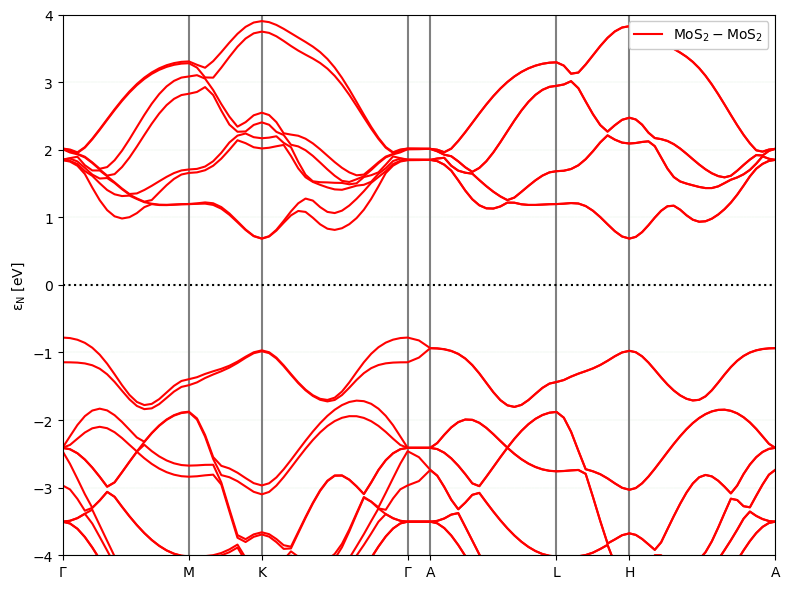

In [7]:
bs_calc = calc.fixed_density(kpts={'path': 'GMKGALHA', 'npoints': 100}, symmetry='off')
 # path through k-space taken from Materials project; or from analysis above

bs_calc.get_potential_energy() # eval at these k-point path
bs = bs_calc.band_structure().subtract_reference()
#bs=bs_calc.band_structure() # generate the plot object
#bs.ylabel(r'$\varepsilon_N(k)$ [eV]', size=24)
bs.plot(ylabel=r'$\mathrm{\varepsilon_N}$ [eV]', label=r'$\mathrm{MoS_{2}-MoS_{2}}$', loc="upper right", color='r', emax=4, emin=-4)
plt.grid(which='major', axis='both', zorder=-1.0, color = 'green', linestyle = '--', linewidth = 0.05)
plt.tight_layout()
#plt.savefig('MoS2-MoS2.eps')
plt.show()

In [9]:
# Get the accurate HOMO and LUMO from the band structure calculator
KS_gap, p1, p2 = bandgap(bs_calc)
#KS_gap, homo, lumo = bs_calc.get_homo_lumo()

Gap: 1.463 eV
Transition (v -> c):
  (s=0, k=46, n=17, [0.00, 0.00, 0.00]) -> (s=0, k=26, n=18, [0.33, 0.33, 0.00])


In [10]:
KS_gap

1.4631762385275104